# Лабораторная работа № 3.
---------------------------

**Выполнил:** Маковеев Никита Владимирович

------------------------


In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statsmodels.api as sm

from datetime import datetime
from sklearn.metrics import mean_squared_error

df = pd.read_csv("tovar_moving.csv",header=0,  index_col=['date'], parse_dates=['date'], ) # считываем датасет
df1 = pd.read_csv("tovar_moving.csv",header=0, parse_dates=['date']) # считываем датасет
df.index.freq = 'D'
df.head(5)

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


### 1. Отложите в test последнее значение временного ряда.

In [20]:
test = df.iloc[-1]
train = df.iloc[:-1]
test, train

(qty    423846.0
 Name: 2013-12-02 00:00:00, dtype: float64,
                  qty
 date                
 2009-12-25   72314.0
 2009-12-26   66586.0
 2009-12-27  125199.0
 2009-12-28   91544.0
 2009-12-29   76995.0
 ...              ...
 2013-11-27  415875.0
 2013-11-28  320717.0
 2013-11-29  444416.0
 2013-11-30  323577.0
 2013-12-01  170665.0
 
 [1438 rows x 1 columns])

### 2. Проанализируйте временной ряд на наличие тренда и сезонности.

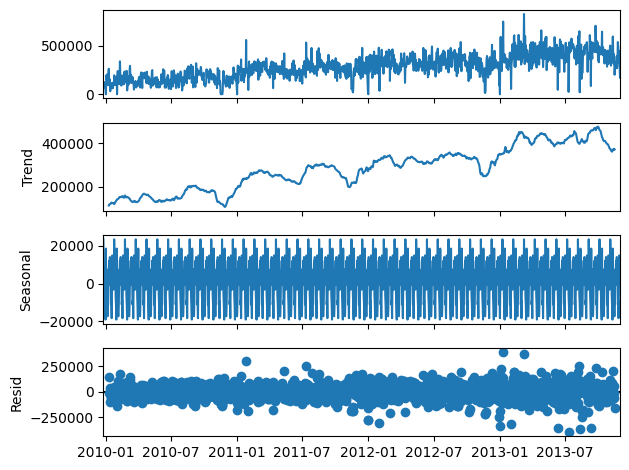

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Декомпозиция временного ряда с указанием периода
decomposed = seasonal_decompose(train, model='additive', period=30)  # Или period=365, если данные дневные

# Визуализация результатов
decomposed.plot()
pyplot.show()

**Результаты:** тренд явно присутсвует. 

### 3. Постройте прогноз на одно последнее значение с помощью экспоненциального сглаживания $\alpha = 0.7$.  Сравните результат с фактическим значением, которое вы отложили вначале.

In [23]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
mse0 = mean_squared_error(test, exp_pred)
print(f"{mse0 / 10**9} * 10^9")

39.53355872437031 * 10^9


### 4. Проверьте ряд на стационарность, определите порядок интегрирования.

In [24]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train)

adf:  -2.255302641033795
p-value:  0.18678903123416635
Critical values:  {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}
есть единичные корни, ряд не стационарен


In [25]:
otg1diff = df.diff(periods=1).dropna()
stat_test(otg1diff)

adf:  -13.821839865226671
p-value:  7.878856681049412e-26
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
единичных корней нет, ряд стационарен


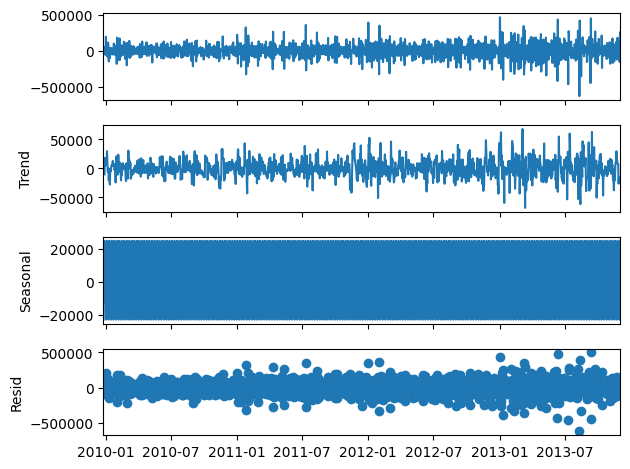

In [49]:
decomposition = seasonal_decompose(otg1diff, model='additive') 
decomposition.plot()
pyplot.show() # любуемся результатом

Порядок интегрирования - 1.

In [26]:
ses = SimpleExpSmoothing(otg1diff)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
exp1_pred = exp_pred.cumsum() + train.iloc[-1]["qty"]
mse1 = mean_squared_error(test, exp1_pred)
print(f"{mse1 / 10**9} * 10^9")


12.995923814593548 * 10^9


Видно, что новый ряд 1 порядка интегрирования, сильно лучше предсказывает наш временной ряд. Тк мы смогли избавиться от тренда.

### 5. Определите порядок модели AR по графику частичной автокорреляции.

1

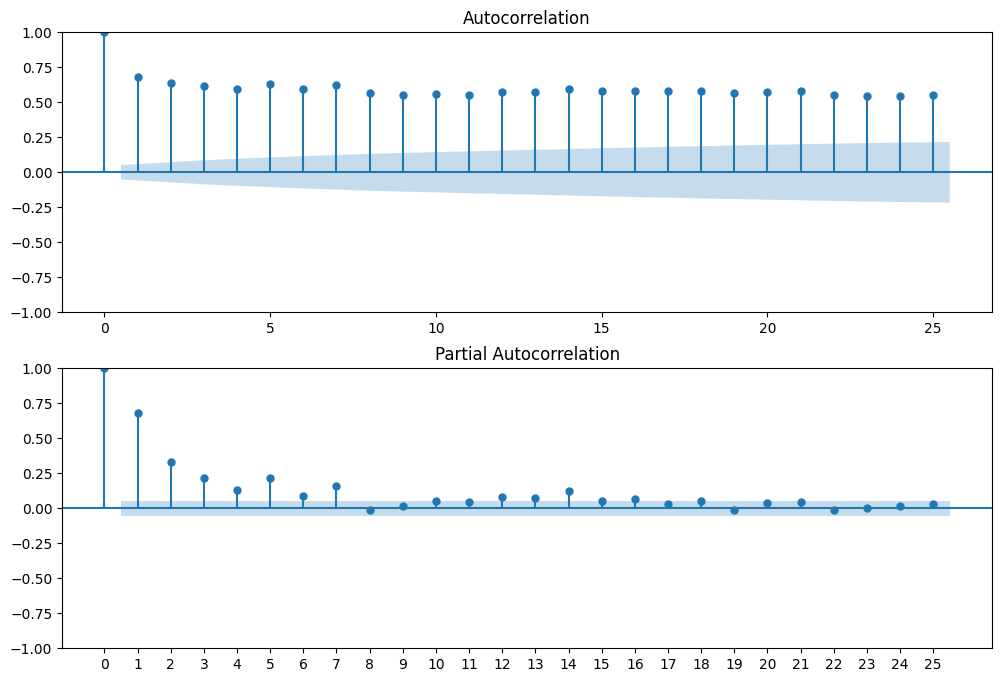

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=25, ax=ax2)
plt.xticks(range(0, 26))
1

Как видно, после p=7 коэфициенты незначительные.

In [46]:
p=7

### 6. Постройте модель AR и предскажите последнее значение ряда. 
**Обратите внимание: модель строится на исходном временном ряду.**

In [47]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(train, lags=p).fit()
# print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train), end=(len(train)), dynamic=False)

### 7. Сравните полученные результаты.

In [48]:
mse_ar, mse_exp = mean_squared_error(test, ar_pred), mean_squared_error(test, exp1_pred)
print(f"mse for AR model {mse_ar // 10**9}; mse for Exp model {mse_exp // 10**9}")


mse for AR model 6.0; mse for Exp model 12.0
